<a href="https://colab.research.google.com/github/MrBenedict/Pneumonia_detection/blob/main/vgg16_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VGG16(pneumonija)

Autorius: Beneiktas Cicėnas

Grupė: DISfm-20

šaltinis: https://www.tensorflow.org/tutorials/images/transfer_learning

duomenų rinkinys: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


## Bibliotekų paruošimas

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 13.8 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Duomenų paruošimas

### Duomenų įsikėlimas

Duomenų rinkinio įsikėlimas naudojant `tf.keras.utils.image_dataset_from_directory`.

In [ ]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')


# Google drive prijungimas
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/'My Drive'/'private/vgtu/magistras/baigiamasis/4.tyrimo rezultatai/'
import os
# Duomenų rinkinio vietos diske
train_dir = 'data/reworked_various/train' # mokymui
validation_dir = 'data/reworked_various/test' # testavimui
test_dir = 'data/reworked_various/val/' # validacijai

BATCH_SIZE = 8
IMG_SIZE = (224, 224)
# mokymo dalis
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Mounted at /content/gdrive
/content/gdrive/My Drive/private/vgtu/magistras/baigiamasis/4.tyrimo rezultatai
Found 1906 files belonging to 2 classes.


In [ ]:
# testavimo dalis
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 630 files belonging to 2 classes.


In [ ]:
# validavimui dalis
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 630 files belonging to 2 classes.


Pirmų devinių pavyzdžių peržiūra

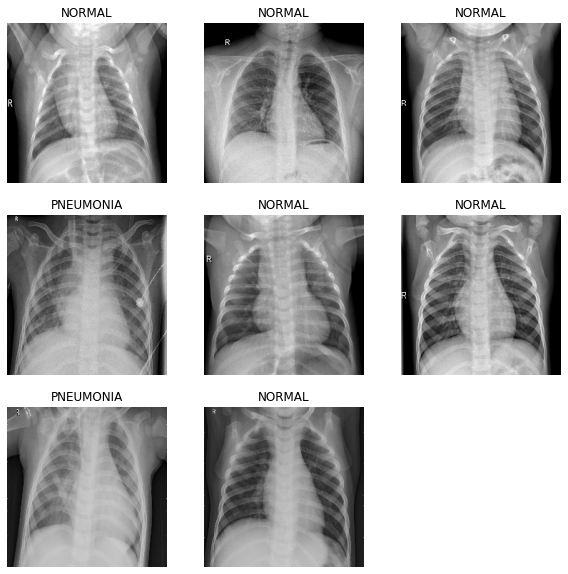

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [ ]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 79
Number of test batches: 79


### Duomenų rinkinio įkėlimo optimizacija

Naudojamas duomenų buferis tam, kad būtų išvengta I/O blokavimo. Daugiau informacijos - [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Duomenų augmentacija

Kai yra naudojamas nedidelis duomenų rinkinys ar dėl tam tikrų priežasčių nėra galimybės turėtų ar gauti daugiau duomenų, taikoma duomenų augmentacija. Tai paprasčiausias metodas padauginti turimus duomenys bei padidinti pavyzdžių įvairovę. Paparasčiausi duomenų augmentacijos metodai: pasūkimas, apsūkimas ir taip toliau. Duomenų augmentacija naudojama norint išvengti persimokymo(angl. overfitting)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./127.5, offset=-1),
  # tf.keras.layers.RandomRotation(0.5)
  tf.keras.layers.RandomZoom(.3, .2),
  tf.keras.layers.RandomContrast(0.1)
  # tf.keras.layers.RandomCrop(224, 224, 0.2)
])

duomenų augmentacijos sluoksniai naudojami tik mokymo metu

Duomenų augmentacijos peržiūra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


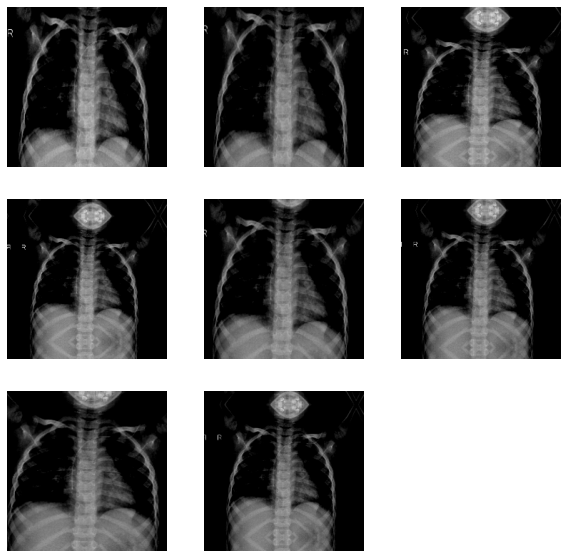

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

### Duomenų mastelio pakeitimas(duomenų normalizacija)

 `tf.keras.applications.MobileNetV2` modelis tikisi pikselių reikšmių intervale `[-1, 1]`, bet duomenų rinkinio nuotraukų pikselių reikšmės yra intervale `[0, 255]`. Kad būtų galima normalizuoti duomenis intervale `[-1, 1]`, galima naudotis `tf.keras.applications.mobilenet_v2.preprocess_input`

In [ ]:
#preprocess_input = tf.keras.applications.densenet.preprocess_input

Kaip alternatvyvą normalizuoti duomenis iš `[0, 255]` į `[-1, 1]` galima taikyti `tf.keras.layers.Rescaling`.

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Bazinio modelio paruošimas


In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 7, 7, 512)


## Požymių ištraukimas(Feature extraction)
Šiame žingsnyje, bazinio modelio konvoliuciniai sluoknsiai bus užrakinimi, kad juose nevyktų mokymas, bei bus pašalinimi klasifikacijai skirti sluoksniai.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Pasiruošimas mokymui

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 512)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1 
                                        #  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.01),
                                        #  activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.01),
                                        #  bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.01),
                                        )
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 1)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
class AUC(tf.keras.metrics.AUC):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self._from_logits:
            super(AUC, self).update_state(y_true, tf.nn.sigmoid(y_pred), sample_weight)
        else:
            super(AUC, self).update_state(y_true, y_pred, sample_weight)


class BinaryAccuracy(tf.keras.metrics.BinaryAccuracy):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self._from_logits:
            super(BinaryAccuracy, self).update_state(y_true, tf.nn.sigmoid(y_pred), sample_weight)
        else:
            super(BinaryAccuracy, self).update_state(y_true, y_pred, sample_weight)


class TruePositives(tf.keras.metrics.TruePositives):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self._from_logits:
            super(TruePositives, self).update_state(y_true, tf.nn.sigmoid(y_pred), sample_weight)
        else:
            super(TruePositives, self).update_state(y_true, y_pred, sample_weight)


class FalsePositives(tf.keras.metrics.FalsePositives):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self._from_logits:
            super(FalsePositives, self).update_state(y_true, tf.nn.sigmoid(y_pred), sample_weight)
        else:
            super(FalsePositives, self).update_state(y_true, y_pred, sample_weight)


class TrueNegatives(tf.keras.metrics.TrueNegatives):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self._from_logits:
            super(TrueNegatives, self).update_state(y_true, tf.nn.sigmoid(y_pred), sample_weight)
        else:
            super(TrueNegatives, self).update_state(y_true, y_pred, sample_weight)


class FalseNegatives(tf.keras.metrics.FalseNegatives):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self._from_logits:
            super(FalseNegatives, self).update_state(y_true, tf.nn.sigmoid(y_pred), sample_weight)
        else:
            super(FalseNegatives, self).update_state(y_true, y_pred, sample_weight)


class Precision(tf.keras.metrics.Precision):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self._from_logits:
            super(Precision, self).update_state(y_true, tf.nn.sigmoid(y_pred), sample_weight)
        else:
            super(Precision, self).update_state(y_true, y_pred, sample_weight)


class Recall(tf.keras.metrics.Recall):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self._from_logits:
            super(Recall, self).update_state(y_true, tf.nn.sigmoid(y_pred), sample_weight)
        else:
            super(Recall, self).update_state(y_true, y_pred, sample_weight)

In [ ]:


base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy',
                        AUC(from_logits=True, name='auc'),
                        Recall(from_logits=True, name='recall'),
                        Precision(from_logits=True, name='precision')
                      ])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0, auc0, recall0, precision0 = model.evaluate(validation_dataset)

79/79 [==============================] - 117s 1s/step - loss: 0.7815 - accuracy: 0.5000 - auc: 0.5554 - recall: 1.0000 - precision: 0.5000


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.78
initial accuracy: 0.50


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(mode='min', patience=1)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/10
239/239 [==============================] - 205s 849ms/step - loss: 0.7132 - accuracy: 0.5399 - auc: 0.5534 - recall: 0.9517 - precision: 0.5084 - val_loss: 0.6816 - val_accuracy: 0.5000 - val_auc: 0.6787 - val_recall: 0.9841 - val_precision: 0.5132
Epoch 2/10
239/239 [==============================] - 45s 186ms/step - loss: 0.6694 - accuracy: 0.5257 - auc: 0.6505 - recall: 0.7345 - precision: 0.5641 - val_loss: 0.6608 - val_accuracy: 0.5000 - val_auc: 0.8085 - val_recall: 0.7556 - val_precision: 0.7126
Epoch 3/10
239/239 [==============================] - 45s 185ms/step - loss: 0.6466 - accuracy: 0.5310 - auc: 0.7521 - recall: 0.7051 - precision: 0.6707 - val_loss: 0.6420 - val_accuracy: 0.5032 - val_auc: 0.8712 - val_recall: 0.7270 - val_precision: 0.8513
Epoch 4/10
239/239 [==============================] - 45s 186ms/step - loss: 0.6241 - accuracy: 0.5682 - auc: 0.8165 - recall: 0.7419 - precision: 0.7388 - val_loss: 0.6241 - val_accuracy: 0.5079 - val_auc: 0.9058 - val_re

## Mokymo rezultatai


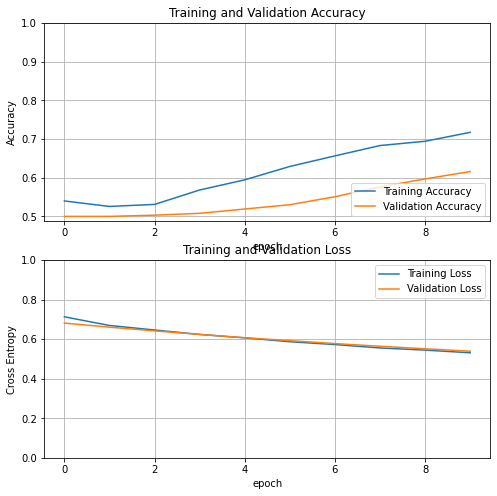

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

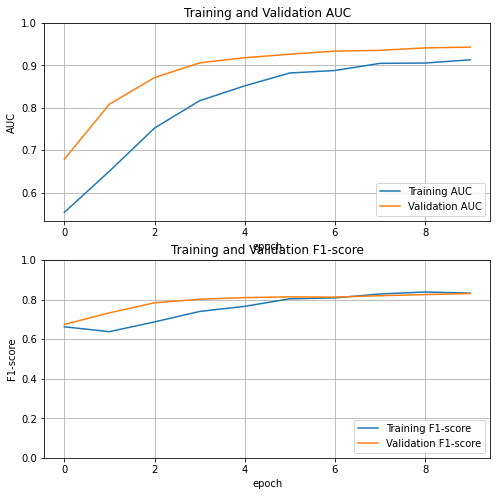

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']

# f1_score = history.history['f1_score']
# val_f1_score = history.history['val_f1_score']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')

f1_score = np.divide(np.multiply(2,np.multiply(history.history['precision'], history.history['recall'])), np.add(history.history['precision'], history.history['recall'])) 
val_f1_score = np.divide(np.multiply(2,np.multiply(history.history['val_precision'], history.history['val_recall'])), np.add(history.history['val_precision'], history.history['val_recall'])) 
plt.xlabel('epoch')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(f1_score, label='Training F1-score')
plt.plot(val_f1_score, label='Validation F1-score')
plt.legend(loc='lower right')
plt.ylabel('F1-score')
plt.ylim([0,1.0])
plt.title('Training and Validation F1-score')
plt.xlabel('epoch')
plt.grid()
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

In [ ]:
loss, accuracy, auc, recall, precision = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

79/79 [==============================] - 121s 1s/step - loss: 0.5336 - accuracy: 0.6175 - auc: 0.9609 - recall: 0.7048 - precision: 0.9911
Test accuracy : 0.617460310459137


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 0 0 0 1 0 1]
Labels:
 [0 1 1 0 0 1 0 1]


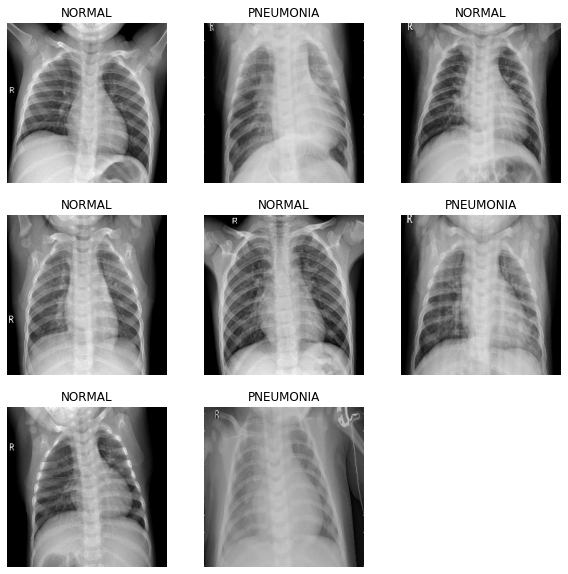

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(8):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")